# 顔文字生成器（サンプル）
単純ニューラルネットワークだけのシンプル構成  
2次元の系列データに対して転置を行うことで系列をが学習させる

In [1]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=182cd825041aae9ef2e649129c582b46881096a39da8ac82540326a463ae1f4f
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

from sklearn.manifold import TSNE

## 前処理

### データ読み込み

In [3]:
# 特殊文字
sp = {'pad': '<PAD>',
      # 'bos': '<BOS>',
      # 'eos': '<EOS>',
      'unk': '<UNK>'}
# pad : padding. 文字列長を一定にするために使う
# bos : begin of sequence. 文頭文字．Decoderの最初の入力
# eos : end of sequence. 文末文字．
# unk : unknown. 出現数が低いものに割り当てる

In [4]:
sp.values()

dict_values(['<PAD>', '<UNK>'])

In [5]:
KAOMOJI_MAX = 10    # 顔文字最大長

kmj_list = []   # 顔文字リスト
len_list = []       # <BOS> から <EOS> までの文字数のリスト
char_list = []      # 顔文字に使用されている文字のリスト

char_list += list(sp.values())
file_name = 'kaomoji_MAX=' + str(KAOMOJI_MAX) + '_DA.txt'

with open(file_name, mode='r') as file:
  for line in file:
    # temp = [sp['bos']]
    temp = list(line.replace('\n', ''))
    # temp += [sp['eos']]
    len_list.append(len(temp))
    temp += [sp['pad'] for _ in range(KAOMOJI_MAX - len(temp))]
    kmj_list.append(temp)
    char_list += temp

# 重複を消す
char_list = sorted(set(char_list), key=char_list.index)

In [6]:
print(kmj_list[0])

['(', '’', '⌒', '’', ')', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [7]:
print('Number of kaomoji  :', len(kmj_list))
print('Number of character:', len(char_list))

Number of kaomoji  : 10300
Number of character: 719


### 出現数が少ないものを置換

In [8]:
# 最小出現数
MIN_APPEAR = 20

kmj_list = np.array(kmj_list)

cnt = 0
for c in char_list:
  mask = (kmj_list == c)
  if np.sum(mask) < MIN_APPEAR:
    kmj_list[mask] = sp['unk']

char_list = list(sp.values()) + kmj_list.flatten().tolist()
char_list = sorted(set(char_list), key=char_list.index)

In [9]:
print('Number of character:', len(char_list))

Number of character: 200


### 添字検索
顔文字に使われる文字が文字リストの何番目にあるか調べる

In [10]:
kmj_index = []    # 添字リスト

for kmj in kmj_list.tolist():
  temp = [char_list.index(c) for c in kmj]
  kmj_index.append(temp)

In [11]:
print(len_list[0])
kmj_index[0]

5


[2, 3, 4, 3, 5, 0, 0, 0, 0, 0]

### One-hotベクトル化



In [12]:
kmj_num = len(kmj_index)        # 顔文字の総数
kmj_size = len(kmj_index[0])    # 1つの顔文字の長さ
char_num = len(char_list)       # 文字の種類数

# One-hotベクトルリスト
kmj_onehot = np.zeros((kmj_num, kmj_size, char_num))

for i, index in enumerate(kmj_index):
  mask = range(char_num) == np.array(index).reshape((kmj_size, 1))
  kmj_onehot[i][mask] = 1

In [13]:
kmj_onehot.shape

(10300, 10, 200)

### 訓練・検証・テスト用に分ける

In [14]:
dataset = torch.utils.data.TensorDataset(
  torch.tensor(kmj_onehot.astype('float32')),
  torch.tensor(len_list)
)

In [15]:
train_size = int(len(dataset) * 0.85)
valid_size = int(len(dataset) * 0.10)
test_size  = len(dataset) - train_size - valid_size

# indices = np.arange(len(dataset))

# dataset_train = torch.utils.data.Subset(dataset, indices[:train_size])
# dataset_valid = torch.utils.data.Subset(dataset, indices[train_size:train_size+valid_size])
# dataset_test  = torch.utils.data.Subset(dataset, indices[train_size+valid_size:])

split = [train_size, valid_size, test_size]

dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, split)

In [16]:
train_size

8755

In [17]:
dataset_train[0]

(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(7))

In [18]:
batch_size = 128

dataloader_train = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
  dataset_valid,
  batch_size=batch_size,
  shuffle=True
)

In [19]:
for x, len_seq in dataloader_train:
  print(x.shape, len_seq.shape)
  break

torch.Size([128, 10, 200]) torch.Size([128])


## モデル

### Encoder

In [20]:
class Encoder(nn.Module):
  def __init__(self, N, char_num, emb_dim, hid_dim):
    super().__init__()
    self.W_emb = nn.Parameter(torch.tensor(np.random.uniform(
                   low=-np.sqrt(6 / (char_num + emb_dim)),
                   high=np.sqrt(6 / (char_num + emb_dim)),
                   size=(char_num, emb_dim)
                 ).astype('float32')))

    self.W_1 = nn.Parameter(torch.tensor(np.random.uniform(
                 low=-np.sqrt(6 / (N + hid_dim)),
                 high=np.sqrt(6 / (N + hid_dim)),
                 size=(emb_dim, N, hid_dim)
               ).astype('float32')))
    self.b_1 = nn.Parameter(torch.tensor(np.zeros((emb_dim, 1, hid_dim)).astype('float32')))

    self.W_2 = nn.Parameter(torch.tensor(np.random.uniform(
                 low=-np.sqrt(6 / (emb_dim + 1)),
                 high=np.sqrt(6 / (emb_dim + 1)),
                 size=(hid_dim, emb_dim, 1)
               ).astype('float32')))
    self.b_2 = nn.Parameter(torch.tensor(np.zeros((hid_dim, 1, 1)).astype('float32')))


  def forward(self, x):
    x = torch.matmul(x, self.W_emb)
    # x = F.tanh(x)
    x = (torch.matmul(x.transpose(-2, -1).unsqueeze(-2), self.W_1) + self.b_1).squeeze(-2)
    # x = F.relu(x)
    x = (torch.matmul(x.transpose(-2, -1).unsqueeze(-2), self.W_2) + self.b_2).squeeze(-2)
    # x = F.relu(x)
    return x

In [21]:
encoder = Encoder(10, 137, 8, 32)
x = torch.rand(16, 10, 137)
encoder(x).shape

torch.Size([16, 32, 1])

### Decoder

In [34]:
class Decoder(nn.Module):
  def __init__(self, N, char_num, emb_dim, hid_dim):
    super().__init__()
    # self.W_1 = nn.Parameter(torch.tensor(np.random.uniform(
    #              low=-np.sqrt(6 / (hid_dim + emb_dim)),
    #              high=np.sqrt(6 / (hid_dim + emb_dim)),
    #              size=(hid_dim, emb_dim)
    #            ).astype('float32')))
    # self.b_1 = nn.Parameter(torch.tensor(np.zeros((hid_dim, emb_dim)).astype('float32')))

    self.W_1 = nn.Parameter(torch.tensor(np.random.uniform(
                 low=-np.sqrt(6 / (hid_dim + emb_dim)),
                 high=np.sqrt(6 / (hid_dim + emb_dim)),
                 size=(hid_dim, hid_dim, emb_dim)
               ).astype('float32')))
    self.b_1 = nn.Parameter(torch.tensor(np.zeros((hid_dim, 1, emb_dim)).astype('float32')))

    self.W_2 = nn.Parameter(torch.tensor(np.random.uniform(
                 low=-np.sqrt(6 / (emb_dim + N)),
                 high=np.sqrt(6 / (emb_dim + N)),
                 size=(emb_dim, hid_dim, N)
               ).astype('float32')))
    self.b_2 = nn.Parameter(torch.tensor(np.zeros((emb_dim, 1, N)).astype('float32')))

    self.W_out = nn.Parameter(torch.tensor(np.random.uniform(
                   low=-np.sqrt(6 / (emb_dim + char_num)),
                   high=np.sqrt(6 / (emb_dim + char_num)),
                   size=(emb_dim, char_num)
                 ).astype('float32')))
    self.b_out = nn.Parameter(torch.tensor(np.zeros((N, char_num)).astype('float32')))

  def forward(self, x):
    # x = x * self.W_1 + self.b_1
    x = (torch.matmul(x.transpose(-2, -1).unsqueeze(-2), self.W_1) + self.b_1).squeeze(-2)
    # x = F.relu(x)
    x = (torch.matmul(x.transpose(-2, -1).unsqueeze(-2), self.W_2) + self.b_2).squeeze(-2)
    # x = F.relu(x)
    x = torch.matmul(x.transpose(-2, -1), self.W_out) + self.b_out
    return x

In [35]:
decoder = Decoder(10, 137, 8, 32)
x = torch.rand(16, 32, 1)
decoder(x).shape

torch.Size([16, 10, 137])

### Generator

In [24]:
class Generator(nn.Module):
  def __init__(self, N, char_num, emb_dim, hid_dim):
    super().__init__()
    self.encoder = Encoder(N, char_num, emb_dim, hid_dim)
    self.decoder = Decoder(N, char_num, emb_dim, hid_dim)

  def forward(self, x):
    z = self.encoder(x)
    y = self.decoder(z)
    return y

In [25]:
generator = Generator(10, 137, 8, 32)
x = torch.rand(16, 10, 137)
generator(x).shape

torch.Size([16, 10, 137])

## 学習

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
n_epochs = 10

N = KAOMOJI_MAX
char_num = len(char_list)
emb_dim = 16
hid_dim = 128

net = Generator(N, char_num, emb_dim, hid_dim)

optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [45]:
for epoch in range(n_epochs):
  losses_train = []
  losses_valid = []
  acc_train = 0
  acc_valid = 0

  # 訓練
  net.train()
  for x, len_seq in dataloader_train:
    net.zero_grad()  # 勾配の初期化

    #x.to(device)
    #t.to(device)

    y = net(x)

    loss = criterion(y, x)
    acc_train += (y.argmax(dim=2) == x.argmax(dim=2)).sum()
    loss.backward()  # 誤差の逆伝播
    losses_train.append(loss.tolist())

    optimizer.step()  # パラメータの更新

  # 検証
  net.eval()
  for x, len_seq in dataloader_valid:
    y = net(x)

    loss = criterion(y, x)
    acc_valid += (y.argmax(dim=2) == x.argmax(dim=2)).sum()
    losses_valid.append(loss.tolist())

  if (epoch+1) % 1 == 0:
    print('EPOCH: {:>3}, Train Loss: {:>4.5f}  Acc: {:>.3f},    Valid Loss: {:>4.5f}  Acc: {:>.3f}'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train / (train_size * N),
        np.mean(losses_valid),
        acc_valid / (valid_size * N)
    ))

EPOCH:   1, Train Loss: 0.08307  Acc: 0.358,    Valid Loss: 0.06141  Acc: 0.491
EPOCH:   2, Train Loss: 0.05143  Acc: 0.541,    Valid Loss: 0.04559  Acc: 0.579
EPOCH:   3, Train Loss: 0.03822  Acc: 0.611,    Valid Loss: 0.03522  Acc: 0.643
EPOCH:   4, Train Loss: 0.03124  Acc: 0.667,    Valid Loss: 0.03105  Acc: 0.690
EPOCH:   5, Train Loss: 0.02753  Acc: 0.715,    Valid Loss: 0.02783  Acc: 0.729
EPOCH:   6, Train Loss: 0.02555  Acc: 0.752,    Valid Loss: 0.02549  Acc: 0.756
EPOCH:   7, Train Loss: 0.02446  Acc: 0.773,    Valid Loss: 0.02522  Acc: 0.770
EPOCH:   8, Train Loss: 0.02376  Acc: 0.785,    Valid Loss: 0.02533  Acc: 0.780
EPOCH:   9, Train Loss: 0.02337  Acc: 0.794,    Valid Loss: 0.02413  Acc: 0.788
EPOCH:  10, Train Loss: 0.02308  Acc: 0.797,    Valid Loss: 0.02386  Acc: 0.790


## 評価

In [46]:
def convert_str(x):
  x = np.array(char_list)[x.argmax(dim=1)]
  x = [c for c in x if c not in sp.values()]

  return ''.join(x)

def generate(net, base=None, rate=0.0, mean=0.0, std=1.0):
  if base is None:
    z_list = net.encoder(dataset_train[:][0])
    z = torch.normal(mean=mean, std=std, size=(hid_dim, 1))
  else:
    z = net.encoder(base.unsqueeze(0))
    eps = 2 * rate * torch.rand(hid_dim, 1) - rate
    z = z + eps

  y = net.decoder(z)
  gen = convert_str(y.squeeze(0))

  return ''.join(gen)

### 次元圧縮テスト
目標はbaseとgenerateで全く同じもの．
次元圧縮して，潜在ベクトルが獲得できているかどうかのテスト．

In [49]:
for i in np.random.randint(0, len(dataset_test), size=10):
  test = dataset_test[i][0]
  print('base     :', convert_str(test))
  print('generate :', generate(net, base=test, rate=0.0))

base     : (　艸́　o)
generate : (　艸́　o)
base     : ;　へ́　)「
generate : ;　Д́　)　
base     : (`∇　́)♪
generate : (`∇　́)♪
base     : ヾ(‿)ノ
generate : ヾ(∀)ノ
base     : (　́-`;)?
generate : (　́ω`;)/
base     : Σ(T□T)
generate : Σ(≦ω≦)♪
base     : (　́-`;)?
generate : (　́ω`;)/
base     : !\(·o·)/
generate : !\(╹o<)/
base     : (*'ρ'*)
generate : (*'ω≦*)
base     : (゚∩゚ρ)
generate : (>≦ω)゙


### 生成テスト
潜在ベクトルに乱数を入力しその出力を見る．

In [64]:
z_list = net.encoder(dataset_train[:][0])
mean = float(torch.mean(z_list))
std = float(torch.mean(torch.std(z_list, dim=1)))
print('mean :{:.5f}   std : {:.5f}'.format(mean, std))
for _ in range(10):
  print('generate :', generate(net, base=None, mean=mean, std=std*0.5))

mean :0.00647   std : 0.27012
generate : ~ノつ;○∂⌒;♪
generate : ♪(ゞ(θ≦・ゝ☆≦
generate : *!。彡>́ェ。
generate : _+<▽∀*彡@☆
generate : ﻿/゚ゞ□　〃◇(。
generate : 、ロ)≧@≦♪)́
generate : 。(/≧﻿≧▽)`
generate : /(́。(。□σ[
generate : (^≧()<o●!
generate : ?Д́。́<♪ノ[


### 類似度テスト
訓練データの中から潜在ベクトルの距離が近いものを見る．

In [ ]:
def similar(net, base, num=10):
  z = net.encoder(base.unsqueeze(0))

  size = list(z.shape)
  size[0] = 0
  z_list = torch.empty(size, dtype=torch.float)
  z_list = net.encoder(dataset_train[:][0])

  diff = z_list - z
  norm = enumerate(torch.norm(diff.reshape(-1, hid_dim), dim=1))
  norm = sorted(norm, key=lambda x: x[1])

  for i in range(num):
    min_index = norm[i][0]
    str = convert_str(dataset_train[min_index][0])
    print('{} : {}'.format(str, norm[i][1]))

In [ ]:
i = np.random.randint(0, len(dataset_test))
test = dataset_test[i][0]
print(convert_str(test), ' : base')
similar(net, test, num=10)

ヾ(▼ー▼)ゝ、!  : base
((▼ー▼) : 3.7695717811584473
ヾ()ノ : 3.8835012912750244
ヾ(∀≦`)〃 : 3.9291176795959473
ヾ(๑╹๑)ノ" : 4.199093818664551
ヾ(゚┏Д。)ノ! : 4.241329193115234
ヾ(*'ー')o♪ : 4.272275924682617
ヾ(๑๑)ノ" : 4.2980852127075195
━(*゚∀゚)ノ━! : 4.352418422698975
||*-ω-)ノ? : 4.374527454376221
ヾ(●′ω`)ノ : 4.409621238708496


### 潜在ベクトルの分布図
t-SNEという次元削減アルゴリズムがあるらしいので，それを使って潜在ベクトルを2次元化して表示

In [ ]:
z_list = net.encoder(dataset_train[:][0]).reshape(1, -1).detach().numpy()
z_reduc = TSNE(n_components=2).fit_transform(z_list).T

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8721 (\N{N-ARY SUMMATION}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


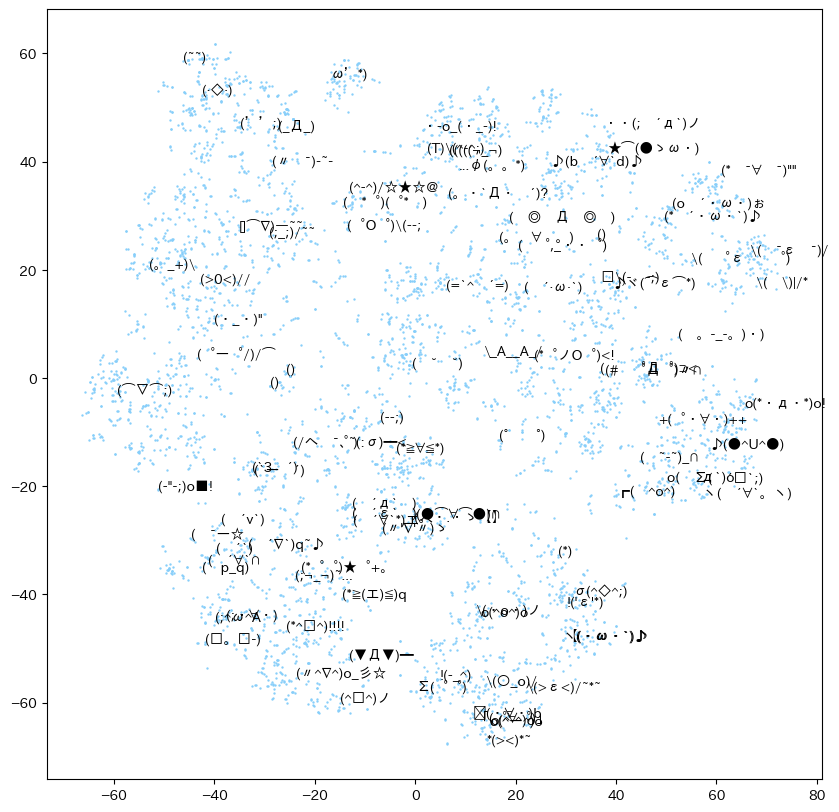

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(*z_reduc, s=0.5, c='lightskyblue')

for i in random.sample(range(len(dataset_train)), 100):
  plt.text(*z_reduc[:, i], convert_str(dataset_train[i][0]), fontsize=10)

plt.show()

### 潜在ベクトルのヒストグラム

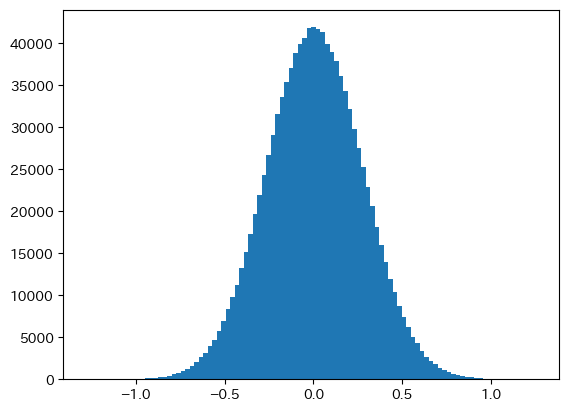

In [ ]:
z_flat = net.encoder(dataset_train[:][0]).detach().numpy().flatten()
c, l, p = plt.hist(z_flat, bins=100)

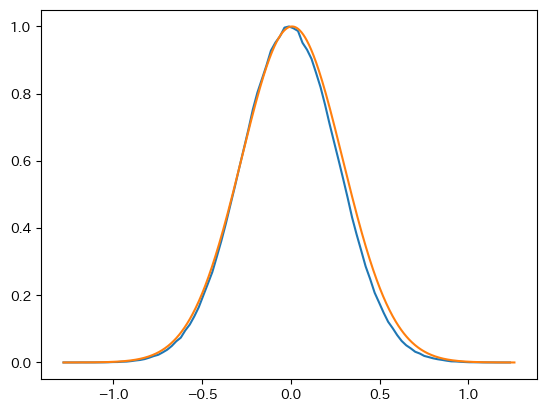

In [ ]:
plt.plot(l[:-1], c / c.max())

n = 1000
x = np.linspace(z_flat.min(), z_flat.max(), n)
y = np.exp(- (x - mean)**2 / (2 * std * 0.3))
plt.plot(x, y)

plt.show()

## 感想

このネットワークは，  
Encoder：Embedding+T+MLP+T+MLP  
Decoder：MLP+T+MLP+T+Linear  
の構成

転置を繰り返し、文字ベクトル方向と系列方向の両方で学習させる．
このときに，行ベクトル毎に異なる重みで計算させる．
計算の度に次元を変え，潜在ベクトルは1次元となる

入力と出力を同じにすることはできるが，ランダム生成はできない．  

似ているものを出力させるときには，潜在ベクトル(今回は行列)に少しノイズを足して計算させている．
このときにも，'( )'は変化しにくい気がする．